In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

In [4]:
img = cv2.imread("/home/hero576/Desktop/lane.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [2]:
def grayscale(img):
    '''灰度变换'''
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
def canny(img,low_threshold,high_threshold):
    '''边缘检测'''
    return cv2.Canny(img,low_threshold,high_threshold)
def gaussian_blur(img,kernel_size):
    '''高斯去噪'''
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
def median_blur(img,kernel_size):
    '''高斯去噪'''
    return cv2.medianBlur(img,kernel_size)
def region_of_interest(img,vertices):
    '''兴趣域'''
    mask = np.zeros_like(img)
    if len(img.shape)>2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    img_masked = cv2.bitwise_and(img,mask)
    return img_masked
def draw_lines(img,lines,color=[255,0,0],thickness=2):
    '''绘制直线'''
    if not lines.any():
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)
def get_y_intercepts(lines,slopes):
    '''根据输入线段的斜率，计算对应y方向的截距和平局斜率'''
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lines = lines.reshape((lines.shape[0]*2,lines.shape[1]//2))
    x_mean,y_mean = np.mean(lines,axis=0)
    return y_mean - (x_mean*avg_slope),avg_slope
def get_x_intercepts(y_1,y_2,slope,b):
    '''根据斜率和截距，及计算对应y值的x'''
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0
    else:
        x_1 = (y_1-b)/slope
        x_2 = (y_2-b)/slope
    return x_1,x_2

In [6]:
prev_left_x1=prev_left_x2=prev_right_x1=prev_right_x2=0
prev_left_avg_m,prev_right_avg_m=-1,1
prev_left_b=prev_right_b=prev_left_line=prev_right_line=0
def draw_lines_extrapolated(img,lines,color=[255,0,0],thickness=3):
    imgshape=img.shape
    lines = lines.reshape((lines.shape[0],lines.shape[2]))
    y_min = lines.reshape((lines.shape[0]*2,lines.shape[1]//2))[:,1].min()
    slopes = (lines[:,3]-lines[:,1])/(lines[:,2]-lines[:,0])
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    left_lines = lines[slopes<-0.5]  # 左边行车道斜率为负
    right_lines = lines[slopes>0.5]  # 右边行车道斜率为正
    left_slopes = slopes[slopes<-0.5]
    right_slopes = slopes[slopes>0.5]
    global prev_left_avg_m
    global prev_right_avg_m
    global prev_left_b
    global prev_right_b
    left_b,left_avg_m = get_y_intercepts(left_lines,left_slopes)
    right_b,right_avg_m = get_y_intercepts(right_lines,right_slopes)
    keep_prev_left = False
    keep_prev_right = False
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
    prev_left_avg_m = left_avg_m
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b
    
    left_x1,left_x2 = get_x_intercepts(y_1=y_min,y_2=imgshape[0],slope=left_avg_m,b=left_b)
    right_x1,right_x2 = get_x_intercepts(y_1=y_min,y_2=imgshape[0],slope=right_avg_m,b=right_b)

    global prev_left_x1
    global prev_left_x2
    global prev_right_x1
    global prev_right_x2

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 != 0:
        alpha = 0.2
        left_x1_new = math.floor(alpha*left_x1+(1-alpha)*prev_left_x1)
        left_x2_new = math.floor(alpha*left_x2+(1-alpha)*prev_left_x2)
        right_x1_new = math.floor(alpha*right_x1+(1-alpha)*prev_right_x1)
        right_x2_new = math.floor(alpha*right_x2+(1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    left_line = np.array([left_x1_new,y_min,left_x2_new,imgshape[0]],dtype=np.int32)
    right_line = np.array([right_x1_new,y_min,right_x2_new,imgshape[0]],dtype=np.int32)
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
    cv2.line(img,(int(left_x1_new),int(y_min)),(int(left_x2_new),int(imgshape[0])),color,thickness)
    cv2.line(img,(int(right_x1_new),int(y_min)),(int(right_x2_new),int(imgshape[0])),color,thickness)
def hough_line(img,rho,theta,threshold,min_line_len,max_line_gap,extrapolate=False):
    '''
    img:canny检测后的图像
    rho:hough检测中grid像素距离
    theta:grid角度距离
    threshold:最小voting数值
    min_line_len:构成线的最小像素个数
    max_line_gap:相连线段之间的最大距离
    extrapolate:
    返回黑背景上有白线的图
    '''
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap=max_line_gap)
    img_line = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    if not extrapolate:
        draw_lines(img_line,lines)
    else:
        draw_lines_extrapolated(img_line,lines)
    return img_line

def weighted_img(img,initial_img,a=0.8,b=1):
    '''
    img:hough检测输出
    initial_img:原始图像
    加权相加：initial_img*a + img*b
    '''
    return cv2.addWeighted(initial_img,a,img,b,0)

[[[  0 285]
  [263 142]
  [263 142]
  [526 285]]]


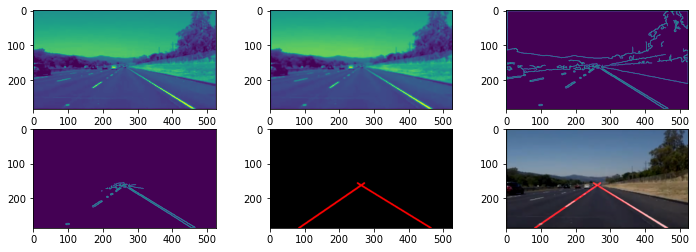

In [7]:
fig = plt.figure(figsize=(12,4))
s = img.shape
img_gray = grayscale(img)
a = fig.add_subplot(2,3,1)
plt.imshow(img_gray)
img_blur = gaussian_blur(img_gray,kernel_size=5)
a = fig.add_subplot(2,3,2)
plt.imshow(img_blur)
img_edge = canny(img_blur,low_threshold=50,high_threshold=150)
a = fig.add_subplot(2,3,3)
plt.imshow(img_edge)
vertices = np.array([[(0,s[0]),(s[1]*0.5,s[0]*0.5),(s[1]*0.5,s[0]*0.5),(s[1],s[0])]],dtype=np.int32)
print(vertices)
masked_edges = region_of_interest(img_edge,vertices)
a = fig.add_subplot(2,3,4)
plt.imshow(masked_edges)
img_hough_line = hough_line(masked_edges,rho=1,theta=np.pi/180,threshold=40,min_line_len=60,max_line_gap=30,extrapolate=True)
a = fig.add_subplot(2,3,5)
plt.imshow(img_hough_line)
img_lanes = weighted_img(img_hough_line,img,0.8,1)
a = fig.add_subplot(2,3,6)
plt.imshow(img_lanes)

In [7]:
class lane_detect:
    def __init__(self):
        self.prev_left_x1=0
        self.prev_left_x2=0
        self.prev_right_x1=0
        self.prev_right_x2=0
        self.prev_left_avg_m=-1
        self.prev_right_avg_m=1
        self.prev_left_b=0
        self.prev_right_b=0
        self.prev_left_line=0
        self.prev_right_line=0
    
    def draw_lines_extrapolated(self,img,lines,color=[255,0,0],thickness=3):
        imgshape=img.shape
        lines = lines.reshape((lines.shape[0],lines.shape[2]))
        y_min = lines.reshape((lines.shape[0]*2,lines.shape[1]//2))[:,1].min()
        slopes = (lines[:,3]-lines[:,1])/(lines[:,2]-lines[:,0])
        slopes = slopes[~np.isnan(slopes)]
        slopes = slopes[~np.isinf(slopes)]
        left_lines = lines[slopes<-0.5]  # 左边行车道斜率为负
        right_lines = lines[slopes>0.5]  # 右边行车道斜率为正
        left_slopes = slopes[slopes<-0.5]
        right_slopes = slopes[slopes>0.5]

        left_b,left_avg_m = get_y_intercepts(left_lines,left_slopes)
        right_b,right_avg_m = get_y_intercepts(right_lines,right_slopes)
        keep_prev_left = False
        keep_prev_right = False
        if left_avg_m < -0.83 or left_avg_m > -0.36:
            left_avg_m = prev_left_avg_m
            left_b = prev_left_b
            keep_prev_left = True
        if right_avg_m > 0.83 or right_avg_m < 0.36:
            right_avg_m = prev_right_avg_m
            right_b = prev_right_b
            keep_prev_right = True
        prev_left_avg_m = left_avg_m
        prev_right_avg_m = right_avg_m
        prev_left_b = left_b
        prev_right_b = right_b

        left_x1,left_x2 = get_x_intercepts(y_1=y_min,y_2=imgshape[0],slope=left_avg_m,b=left_b)
        right_x1,right_x2 = get_x_intercepts(y_1=y_min,y_2=imgshape[0],slope=right_avg_m,b=right_b)

        if self.prev_left_x1 != 0 or self.prev_left_x2 != 0 or self.prev_right_x1 != 0 or self.prev_right_x2 != 0:
            alpha = 0.2
            left_x1_new = math.floor(alpha*left_x1+(1-alpha)*self.prev_left_x1)
            left_x2_new = math.floor(alpha*left_x2+(1-alpha)*self.prev_left_x2)
            right_x1_new = math.floor(alpha*right_x1+(1-alpha)*self.prev_right_x1)
            right_x2_new = math.floor(alpha*right_x2+(1-alpha)*self.prev_right_x2)
            self.prev_left_x1 = left_x1_new
            self.prev_left_x2 = left_x2_new
            self.prev_right_x1 = right_x1_new
            self.prev_right_x2 = right_x2_new
        else:
            left_x1_new = left_x1
            left_x2_new = left_x2
            right_x1_new = right_x1
            right_x2_new = right_x2
            self.prev_left_x1 = left_x1_new
            self.prev_left_x2 = left_x2_new
            self.prev_right_x1 = right_x1_new
            self.prev_right_x2 = right_x2_new
        left_line = np.array([left_x1_new,y_min,left_x2_new,imgshape[0]],dtype=np.int32)
        right_line = np.array([right_x1_new,y_min,right_x2_new,imgshape[0]],dtype=np.int32)
        if keep_prev_left:
            left_line = self.prev_left_line
            left_x1_new = self.prev_left_x1
            left_x2_new = self.prev_left_x2
        if keep_prev_right:
            right_line = self.prev_right_line
            right_x1_new = self.prev_right_x1
            right_x2_new = self.prev_right_x2
        cv2.line(img,(int(left_x1_new),int(y_min)),(int(left_x2_new),int(imgshape[0])),color,thickness)
        cv2.line(img,(int(right_x1_new),int(y_min)),(int(right_x2_new),int(imgshape[0])),color,thickness)
        
    def hough_line(self,img,rho,theta,threshold,min_line_len,max_line_gap,extrapolate=False):
        '''
        img:canny检测后的图像
        rho:hough检测中grid像素距离
        theta:grid角度距离
        threshold:最小voting数值
        min_line_len:构成线的最小像素个数
        max_line_gap:相连线段之间的最大距离
        extrapolate:
        返回黑背景上有白线的图
        '''
        lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap=max_line_gap)
        img_line = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
        if not extrapolate:
            self.draw_lines(img_line,lines)
        else:
            self.draw_lines_extrapolated(img_line,lines)
        return img_line

    def weighted_img(self,img,initial_img,a=0.8,b=1):
        '''
        img:hough检测输出
        initial_img:原始图像
        加权相加：initial_img*a + img*b
        '''
        return cv2.addWeighted(initial_img,a,img,b,0)
    
    
    def detect(self,image):
        fig = plt.figure(figsize=(12,4))
        s = img.shape
        img_gray = grayscale(img)
        a = fig.add_subplot(2,3,1)
        plt.imshow(img_gray)
        img_blur = gaussian_blur(img_gray,kernel_size=5)
        a = fig.add_subplot(2,3,2)
        plt.imshow(img_blur)
        img_edge = canny(img_blur,low_threshold=50,high_threshold=150)
        a = fig.add_subplot(2,3,3)
        plt.imshow(img_edge)
        vertices = np.array([[(0,s[0]),(s[1]*0.5,s[0]*0.5),(s[1]*0.5,s[0]*0.5),(s[1],s[0])]],dtype=np.int32)
        print(vertices)
        masked_edges = region_of_interest(img_edge,vertices)
        a = fig.add_subplot(2,3,4)
        plt.imshow(masked_edges)
        img_hough_line = self.hough_line(masked_edges,rho=1,theta=np.pi/180,threshold=40,min_line_len=60,max_line_gap=30,extrapolate=True)
        a = fig.add_subplot(2,3,5)
        plt.imshow(img_hough_line)
        img_lanes = self.weighted_img(img_hough_line,img,0.8,1)
        a = fig.add_subplot(2,3,6)
        plt.imshow(img_lanes)

[[[  0 285]
  [263 142]
  [263 142]
  [526 285]]]


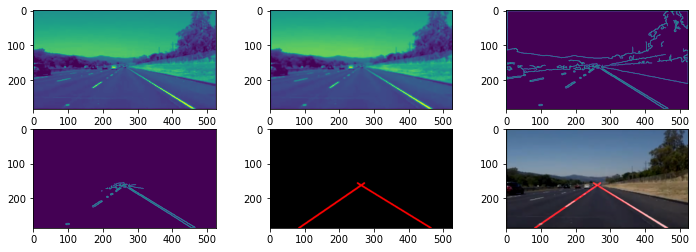

In [9]:
l = lane_detect()
img = cv2.imread("/home/hero576/Desktop/lane.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
lines = l.detect(img)
lines